# Architectural Tradeoff Analysis (PCA)

In [7]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from paretoset import paretoset
import plotly.express as px
import pandas as pd
from adjustText import adjust_text
from pcatools import *

In [8]:
# Read simulation data
# Full = with SQS
df_full = pd.DataFrame(
    pd.read_csv(r"C:\Users\KarlO\architectural-tradeoff-analysis\Simulation data\official_runs\full_1.csv"))
# Simple = without SQS
df_simple = pd.DataFrame(
    pd.read_csv(r"C:\Users\KarlO\architectural-tradeoff-analysis\Simulation data\official_runs\simple_1.csv"))

df = pd.concat([df_full, df_simple])

## Parameter Information

In [9]:
parameter_names = ['queue_size', 'timeout','parallel_instances','lambda_chunk_size']
printParameterScatter(df, parameter_names= parameter_names, color_variable="e_SQS", plot_title="Parameter Values in Data")

# Pareto Front Optimisation

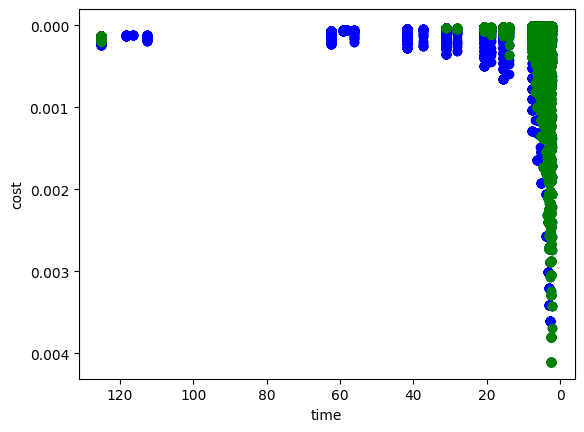

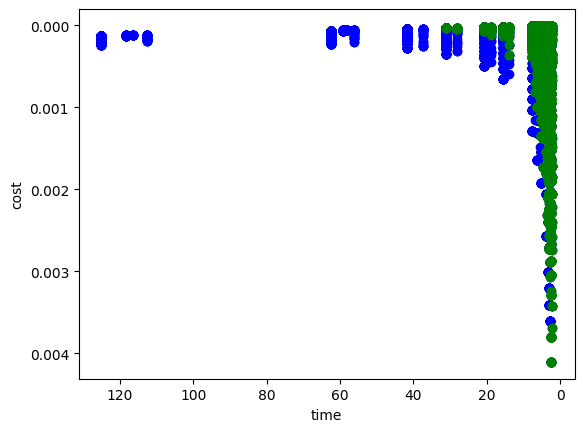

In [10]:
pareto_targets = ['time', 'cost']
pareto_objectives = ["min", "min"]
df_pareto = paretoOptimize(df,pareto_targets, pareto_objectives, iterations = 600)
printPareto(df,df_pareto, pareto_targets, True)

# Filter outliers
df_pareto = df_pareto[df_pareto.time < 80]
printPareto(df,df_pareto, pareto_targets, True)

# PCA Analysis

In [11]:
# Create correlation matrix on scaled data
corr_opt = scaleData(df_pareto).corr()
corr_opt = corr_opt.fillna(0)

# Same for full matrix (without pareto)
corr_full = scaleData(df).corr()
corr_full = corr_full.fillna(0)

# assign categories
categories = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1])
 
# use colormap
colormap = np.array(['b', 'g'])

## PCA Analysis of Full data

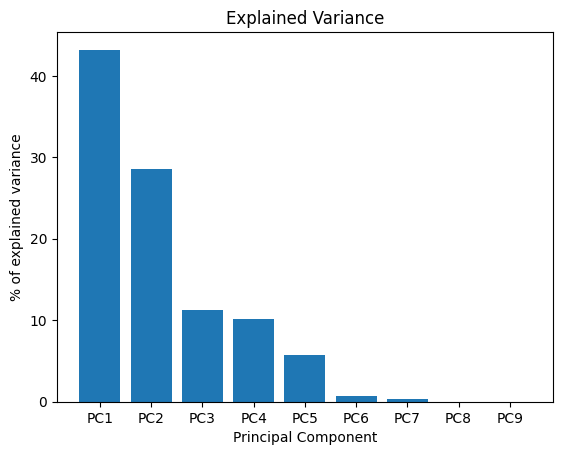

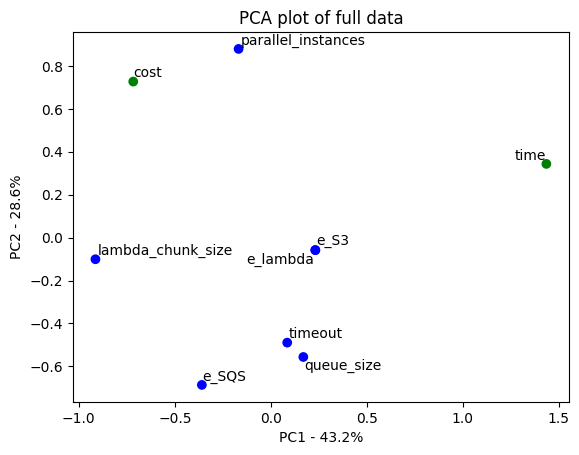

In [12]:
pca, pca_data = createPCA(corr_full)
printScree(pca, 'Explained Variance')
printPCA(pca, pca_data, corr_full, 'PCA plot of full data',categories=categories, colormap=colormap)

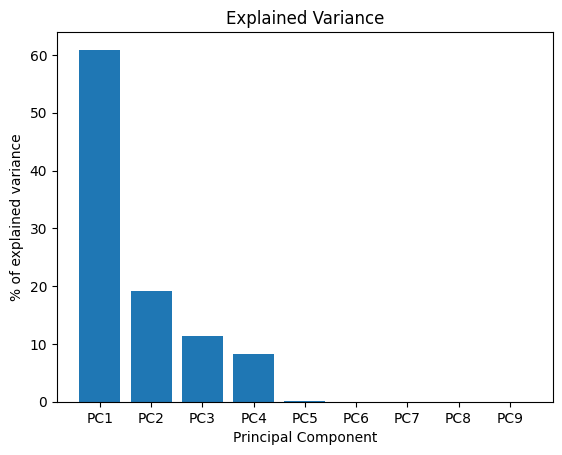

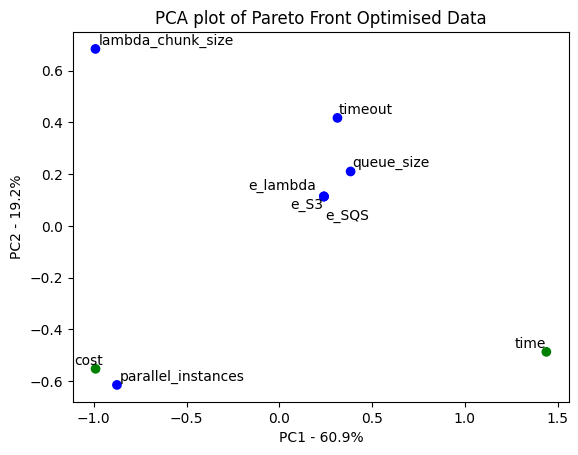

In [15]:
pca, pca_data = createPCA(corr_opt)
printScree(pca, 'Explained Variance')
printPCA(pca, pca_data, corr_full, 'PCA plot of Pareto Front Optimised Data',categories=categories, colormap=colormap)